# Backtest vectorizado y optimización de parametros con Pandas.

---

En este Notebook vamos a realizar un backtest de una estrategia sencilla. Se trata de un cruce de medias, que se puede considerar el "Hello World!" de los sistemas automáticos.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente realizarmos una optimización de los parametros del sistema, y veremos como el calculo vectorizador nos permite hacer un gran número de backtests para la optimización en un tiempo muy breve.

---

# IMPORTACIÓN DE MODULOS Y CARGA DE DATOS


Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado **analisis**, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.

In [12]:
import pandas as pd
import analisis
import numpy as np
import itertools
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

Importamos el modulo **quandl** que nos proporcionará una descarga de los datos que vamos a necesitar, en este caso la cotización diaria de las acciones de Apple.  

In [2]:
import quandl
# quandl.ApiConfig.api_key = "Aquí va tu API KEY" # Para una descarga ocasional no necesitas la API KEY.
qd_data = quandl.get("WIKI/AAPL", start_date= "2000-01-01", end_date= "2018-06-15")

Tambien puedes cargar los datos desde el archivo pickle.

In [3]:
# qd_data = pd.read_pickle('apple_qd.pkl')

Veamos la cabecera del dataframe que acabamos de crear con los datos descargados.

In [3]:
qd_data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,104.87,112.50,101.69,111.94,4783900.0,0.0,1.0,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0,0.0,1.0,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0,0.0,1.0,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0,0.0,1.0,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,96.50,101.00,95.50,99.50,4113700.0,0.0,1.0,3.100399,3.244977,3.068270,3.196784,115183600.0


La tabla muestra que tenemos datos sin ajustar y ajustados. Tomaremos solo los datos OHLCV ajustados y el volumen, prescindiremos del resto de columnas, y eliminaremos el prefijo __Adj.__ para mas comodidad de uso.

In [4]:
ajustadas = [f for f in qd_data.columns if f.startswith('Adj')]
qd_data = qd_data[ajustadas].copy()
qd_data.columns = [f[5:] for f in qd_data.columns]
qd_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,3.100399,3.244977,3.068270,3.196784,115183600.0


Para usarlo en nuestro backtest vamos a hacer una copia del dataframe pero solo hasta 2017.

In [5]:
data = qd_data[:'2016'].copy()

---


# DEFINICION DEL SISTEMA

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.

Esta estrategia utiliza dos medias simples del precio de cierre, de 20 y 60 periodos. Calculemoslas y asignamos sus valores a nuevas columnas de nuestro dataframe.

Para ello usamos la función **rolling** de Pandas, que va _rodando_ una ventana de N valores, sobre la que realiza un calculo, en este caso la media.

In [6]:
data['SMA_20'] = data.Close.rolling(20).mean()
data['SMA_60'] = data.Close.rolling(60).mean()

Como lo que nos interesa es su cruce, para saber cuando se produce calcularemos la diferencia entre ambas medias para cada muestra. Y el signo de la diferencia será la señal para establecer la posición del sistema.

Así cuando la diferencia sea positiva, significará que la media de 20 periodos es mayor que la de 60 periodos, indicando una tendencia alcista y tomando una posición compradora. Con una diferencia negativa, la lógica es justo la inversa y tomaremos posicion vendedora.

In [7]:
data['Dif_SMA'] = data.SMA_20 - data.SMA_60
data['Senal'] = np.sign(data.Dif_SMA)

Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar.

In [8]:
data['Dif_Close'] = data.Close.pct_change()

data['Retornos'] = data.Dif_Close * data.Senal.shift(1)

El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

In [9]:
data['Capital'] = (data.Retornos + 1).cumprod() * 100

Veamos como queda la tabla, tras añadir estas columnas.

Observamos de la fila 58 en adelante, pues hasta que no existen 60 filas no es posible calcular el SMA_60, y por tanto no tenemos señal para tomar posición.

In [10]:
data[58:100]

,Open,High,Low,Close,Volume,SMA_20,SMA_60,Dif_SMA,Senal,Dif_Close,Retornos,Capital
Date,,,,,,,,,,,,
2000-03-27,4.421843,4.650598,4.397747,4.483851,69795600.0,4.069956,NaN,NaN,NaN,0.006273,NaN,NaN
2000-03-28,4.409634,4.562245,4.405779,4.470036,50741600.0,4.109330,3.672270,0.437060,1.0,-0.003081,NaN,NaN
2000-03-29,4.478068,4.479996,4.299755,4.367546,59959200.0,4.118374,3.685121,0.433253,1.0,-0.022928,-0.022928,97.707180
2000-03-30,4.291080,4.423771,4.030197,4.040157,103600000.0,4.124398,3.697571,0.426827,1.0,-0.074960,-0.074960,90.383095
2000-03-31,4.094454,4.409634,4.048189,4.363369,101158400.0,4.136944,3.714604,0.422340,1.0,0.080000,0.080000,97.613743
2000-04-03,4.353410,4.481924,4.158711,4.283048,82140800.0,4.149185,3.735118,0.414067,1.0,-0.018408,-0.018408,95.816862
2000-04-04,4.261201,4.273088,3.751001,4.090277,165082400.0,4.156317,3.750010,0.406308,1.0,-0.045008,-0.045008,91.504348
2000-04-05,4.063289,4.269233,3.983932,4.188912,114416400.0,4.169779,3.767482,0.402297,1.0,0.024114,0.024114,93.710918
2000-04-06,4.196944,4.321281,3.959836,4.022165,64906800.0,4.174502,3.784853,0.389649,1.0,-0.039807,-0.039807,89.980594


Veamos gráficamente como evoluciona el precio y las dos medias.

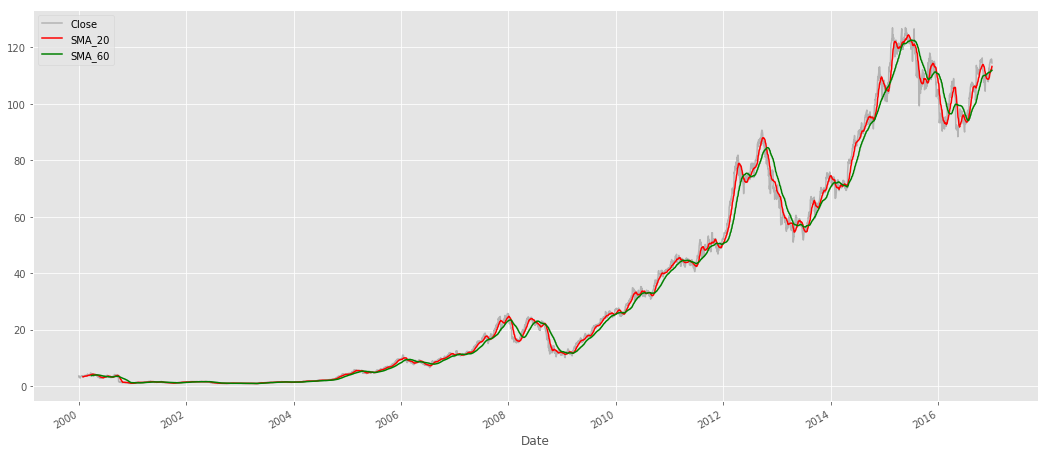

In [13]:
data[['Close','SMA_20','SMA_60']].plot(color=['0.7','r','g'])
plt.show()

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [14]:
def grafico (df):
    estudio = df.copy()
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    ax1.plot(estudio.Capital.fillna(100))
    ax1.plot((estudio.Close) *100 / estudio.Close[0])
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

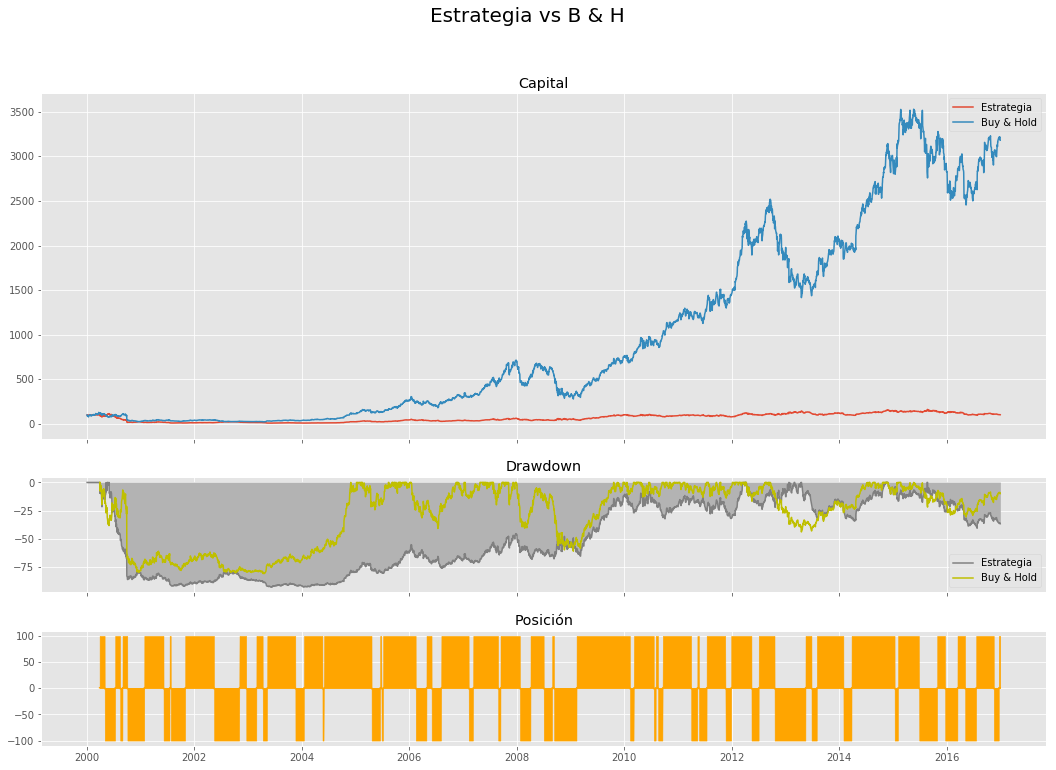

In [15]:
grafico(data)

---

In [20]:
data['Dif_Open'] = data.Open.pct_change()
data['Posicion'] = data.Senal.shift(1)
data['Retornos'] = data.Posicion.shift(1) * data.Dif_Open
data['Capital'] = (data.Retornos.fillna(0) + 1).cumprod() * 100

In [21]:
data[55:70]

,Open,High,Low,Close,Volume,SMA_20,SMA_60,Dif_SMA,Senal,Dif_Close,Retornos,Capital,Dif_Open,Posicion
Date,,,,,,,,,,,,,,
2000-03-22,4.266020,4.638711,4.226823,4.632606,141999200.0,3.940253,NaN,NaN,NaN,0.068549,NaN,100.000000,0.083388,NaN
2000-03-23,4.562245,4.831481,4.497988,4.540076,140641200.0,3.982197,NaN,NaN,NaN,-0.019974,NaN,100.000000,0.069438,NaN
2000-03-24,4.576381,4.624574,4.353410,4.455900,111728400.0,4.027691,NaN,NaN,NaN,-0.018541,NaN,100.000000,0.003099,NaN
2000-03-27,4.421843,4.650598,4.397747,4.483851,69795600.0,4.069956,NaN,NaN,NaN,0.006273,NaN,100.000000,-0.033769,NaN
2000-03-28,4.409634,4.562245,4.405779,4.470036,50741600.0,4.109330,3.672270,0.437060,1.0,-0.003081,NaN,100.000000,-0.002761,NaN
2000-03-29,4.478068,4.479996,4.299755,4.367546,59959200.0,4.118374,3.685121,0.433253,1.0,-0.022928,NaN,100.000000,0.015519,1.0
2000-03-30,4.291080,4.423771,4.030197,4.040157,103600000.0,4.124398,3.697571,0.426827,1.0,-0.074960,-0.041756,95.824365,-0.041756,1.0
2000-03-31,4.094454,4.409634,4.048189,4.363369,101158400.0,4.136944,3.714604,0.422340,1.0,0.080000,-0.045822,91.433491,-0.045822,1.0
2000-04-03,4.353410,4.481924,4.158711,4.283048,82140800.0,4.149185,3.735118,0.414067,1.0,-0.018408,0.063245,97.216243,0.063245,1.0


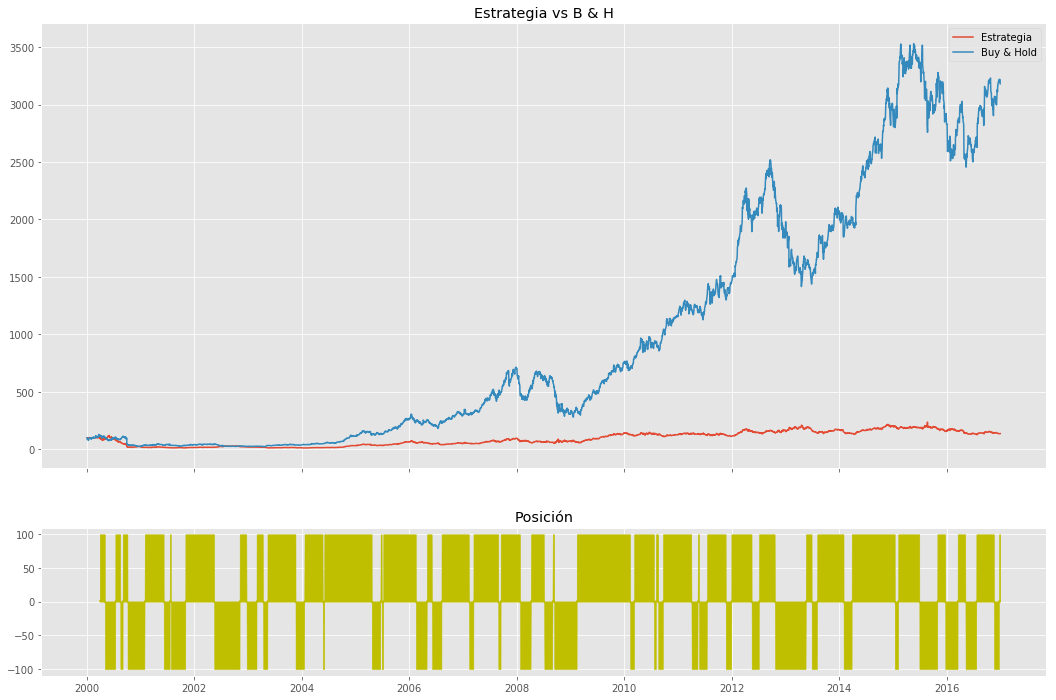

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1]})
ax1.plot(data.Capital)
ax1.plot(data.Close *100 / data.Close[0])
ax1.set_title('Estrategia vs B & H')
ax1.legend(['Estrategia','Buy & Hold'])
ax2.plot(data.Posicion, c='y')
ax2.fill_between(data.index, 0, data.Posicion*100, color='y')
ax2.set_title('Posición')
plt.show()

---

# ANALISIS DEL SISTEMA

In [23]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[0]
print ('Beneficio Bruto : {:.2f}'.format(Beneficio_Bruto))

Beneficio Bruto : 36.64


In [24]:
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : 1.85%


In [31]:
DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(data.Retornos) 


Máximo Drawdown : 91.01% 
Inicio : 2000-06-01 
Fin    : 2009-09-18


In [32]:
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : 0.019


---

# OPTIMIZACION DEL SISTEMA

In [6]:
op_data = qd_data[:'2016'].copy()
op_data['Dif_Close'] = op_data.Close.pct_change()
op_data['Dif_Open'] = op_data.Open.pct_change()

In [9]:
def estrategia_medias (df, periodo_rapido, periodo_lento):
    
    estr = df.copy()
    estr[f'SMA_{periodo_rapido}'] = estr.Close.rolling(periodo_rapido).mean()
    estr[f'SMA_{periodo_lento}'] = estr.Close.rolling(periodo_lento).mean()
    estr['Dif_SMA'] = estr[f'SMA_{periodo_rapido}'] - estr[f'SMA_{periodo_lento}']    
    estr['Senal'] = estr.Dif_SMA / estr.Dif_SMA.abs()
    estr['Posicion'] = estr.Senal.shift(1)    
    estr['Retornos'] = estr.Posicion.shift(1) * estr.Dif_Open    
    estr['Capital'] = (estr.Retornos+1).cumprod() * 100
    
    resultados = {'Rapida' : periodo_rapido, 'Lenta' : periodo_lento}
    resultados['Beneficio Bruto'] = round(estr.Capital[-1]-100,2)
    resultados['CAGR'] = analisis.CAGR(estr.Retornos) 
    resultados['Sharpe'] = resultados['CAGR'] / (np.log(estr.Retornos + 1).std(skipna=True) * 252 ** 0.5)
    resultados['Máximo Drawdown'] = (estr.Capital.div(estr.Capital.cummax()).sub(1)).min()
    
    resultados['Número de trades'] = (np.sign(estr.Posicion * estr.Posicion.shift(1)) == -1).sum() 
    
    return estr, resultados

In [15]:
periodos_rapido = range (5,160,5)
periodos_lento = range (20,210,5)


In [18]:
%%time

coleccion = {}
resultados = {}

for periodo_rapido in periodos_rapido:
    for periodo_lento in periodos_lento:

        
        if periodo_lento <= periodo_rapido:
            continue
        estr, resultado = estrategia_medias (op_data, periodo_rapido, periodo_lento)
        nombre = f'estrategia_{periodo_rapido}_{periodo_lento}'
        coleccion[nombre] = estr
        resultados[nombre] = resultado


CPU times: user 31 s, sys: 256 ms, total: 31.2 s
Wall time: 31.2 s


In [17]:
print ('Realizados {} backtests sobre una serie de {} muestras'.format(len(coleccion), op_data.shape[0]))

Realizados 4830 backtests sobre una serie de 4277 muestras


In [38]:
clasificacion = pd.DataFrame(resultados).transpose()
clasificacion.head(25)

,Beneficio Bruto,CAGR,Lenta,Máximo Drawdown,Número de trades,Rapida,Sharpe
estrategia_5_20,-25.02,-0.016792,20.0,-0.823709,258.0,5.0,-0.038811
estrategia_5_25,136.48,0.051924,25.0,-0.708524,220.0,5.0,0.120077
estrategia_5_30,-43.89,-0.033412,30.0,-0.818304,204.0,5.0,-0.077246
estrategia_5_35,78.47,0.034655,35.0,-0.701457,178.0,5.0,0.080195
estrategia_5_40,106.69,0.043626,40.0,-0.724310,170.0,5.0,0.100971
estrategia_5_45,438.76,0.104121,45.0,-0.604042,164.0,5.0,0.241298
estrategia_5_50,138.51,0.052452,50.0,-0.694788,146.0,5.0,0.121407
estrategia_5_55,147.00,0.054621,55.0,-0.702720,130.0,5.0,0.126554
estrategia_5_60,548.58,0.116233,60.0,-0.692824,120.0,5.0,0.269547
estrategia_5_65,538.70,0.115225,65.0,-0.718123,112.0,5.0,0.267492


In [39]:
pd.DataFrame(clasificacion['Beneficio Bruto'].sort_values(ascending=False).head(10))

,Beneficio Bruto
estrategia_5_185,4603.03
estrategia_50_55,4297.42
estrategia_5_155,3016.42
estrategia_5_140,2861.66
estrategia_5_180,2811.86
estrategia_5_170,2549.15
estrategia_130_165,2538.37
estrategia_5_165,2515.27
estrategia_50_65,2372.41
estrategia_5_190,2330.30


In [40]:
pd.DataFrame(clasificacion.Sharpe.sort_values(ascending=False).head(10))

,Sharpe
estrategia_5_185,0.602860
estrategia_50_55,0.578373
estrategia_5_155,0.528667
estrategia_5_140,0.520018
estrategia_5_180,0.518079
estrategia_130_165,0.502073
estrategia_5_170,0.501432
estrategia_5_190,0.501186
estrategia_5_165,0.499346
estrategia_5_150,0.484983


In [41]:
pd.DataFrame(clasificacion['Máximo Drawdown'].sort_values(ascending=False).head(10))

,Máximo Drawdown
estrategia_50_65,-0.571492
estrategia_50_55,-0.575211
estrategia_45_70,-0.585796
estrategia_5_115,-0.586536
estrategia_50_70,-0.588682
estrategia_45_55,-0.600846
estrategia_5_45,-0.604042
estrategia_45_60,-0.609006
estrategia_45_65,-0.609639
estrategia_5_140,-0.622234


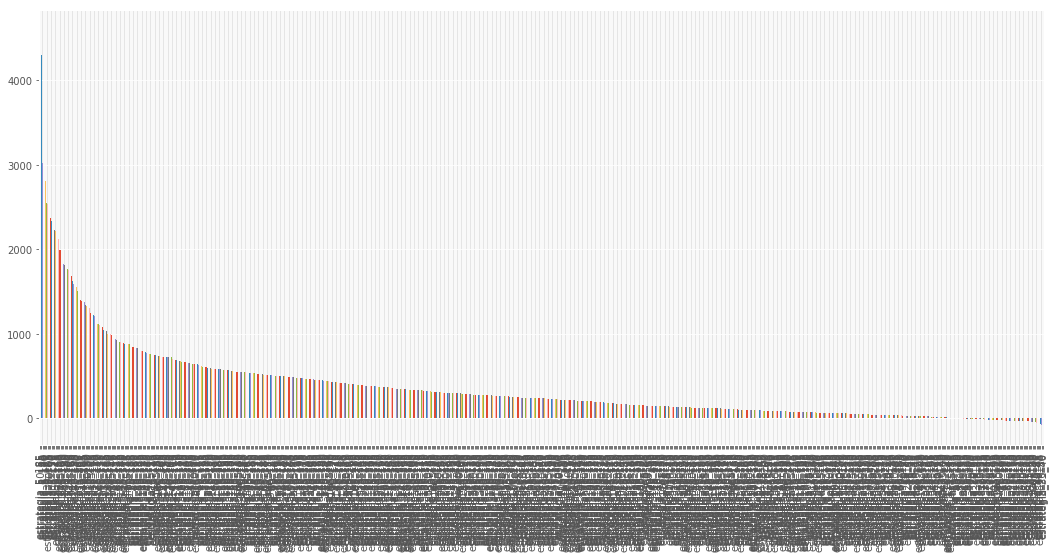

In [42]:
clasificacion['Beneficio Bruto'].sort_values(ascending=False).plot(kind='bar')

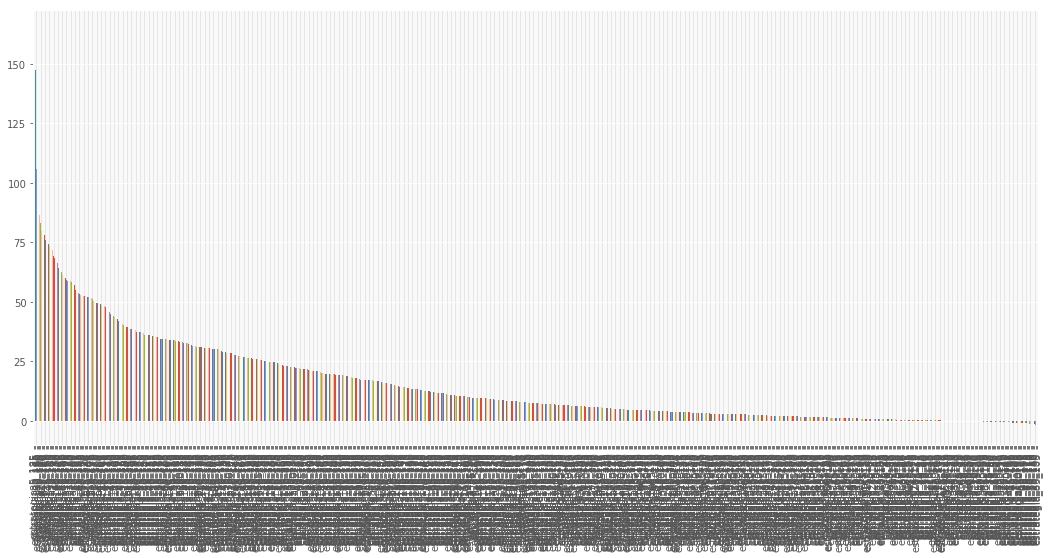

In [43]:
(clasificacion['Beneficio Bruto']/clasificacion['Número de trades']).sort_values(ascending=False).plot(kind='bar')

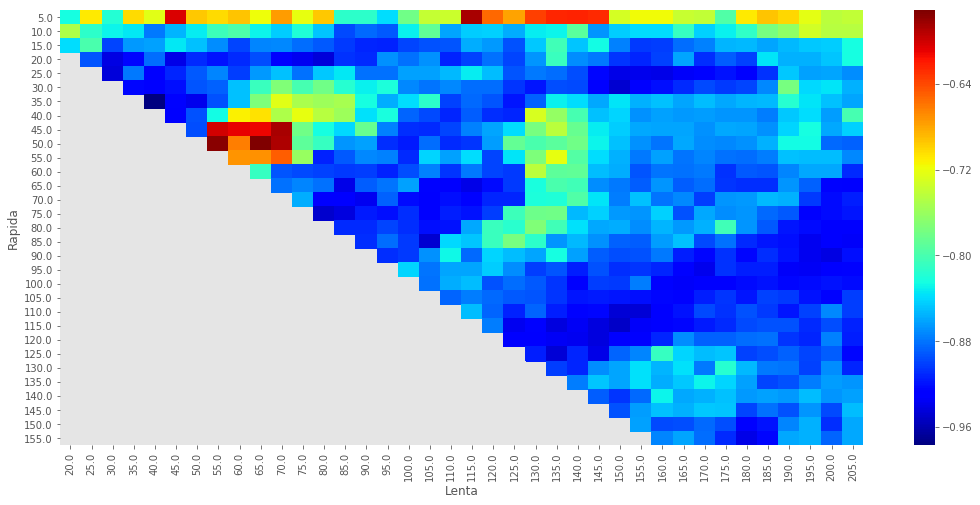

In [44]:
ax=sns.heatmap(clasificacion.pivot('Rapida','Lenta','Máximo Drawdown'), annot=False, fmt=".3", linewidths=0, cmap=plt.cm.jet)

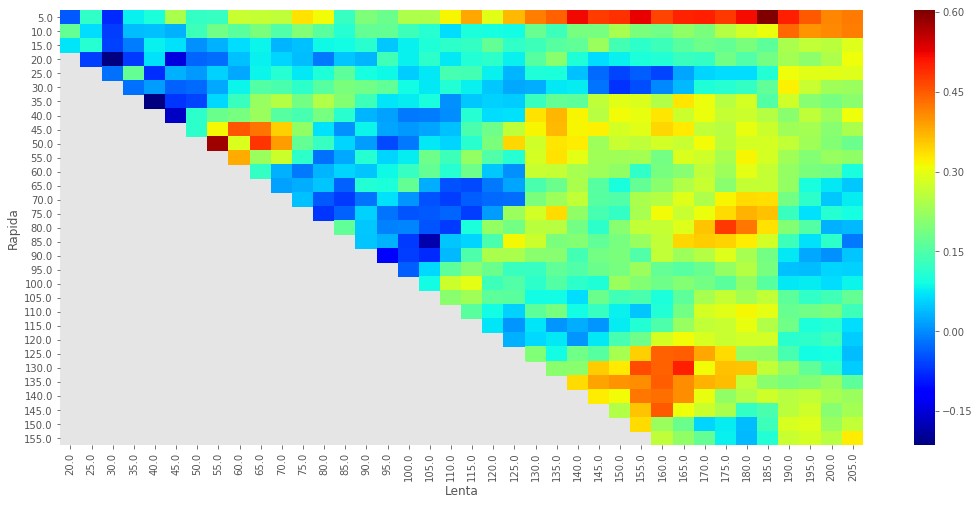

In [45]:
# ax=sns.heatmap(clasificacion.pivot('Rapida','Lenta','Sharpe'), annot=True, fmt=".3f", cmap=plt.cm.jet)
ax=sns.heatmap(clasificacion.pivot('Rapida','Lenta','Sharpe'), annot=False, fmt=".1f", cmap=plt.cm.jet )

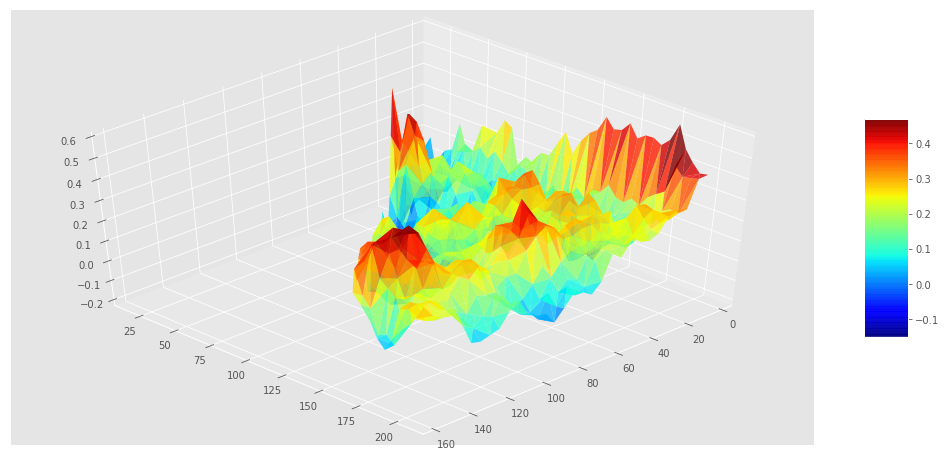

In [46]:
analisis.trisurf_heatmap (clasificacion, 'Rapida', 'Lenta','Sharpe', v1=45, v2=45)

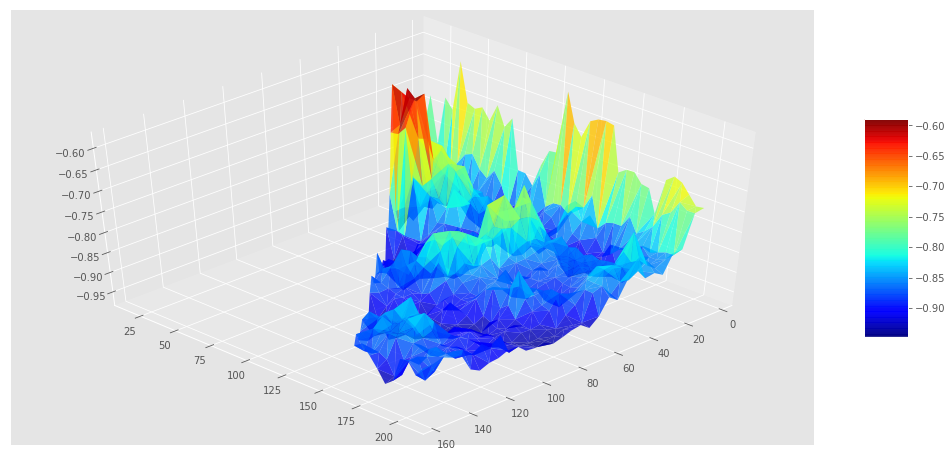

In [47]:
analisis.trisurf_heatmap (clasificacion, 'Rapida', 'Lenta','Máximo Drawdown',v1= 45, v2=45)

---

# REVISIÓN DE LOS PARÁMETROS SELECCIONADOS

In [48]:
pd.DataFrame(clasificacion.loc['estrategia_5_140'])

,estrategia_5_140
Beneficio Bruto,2861.660000
CAGR,0.220526
Lenta,140.000000
Máximo Drawdown,-0.622234
Número de trades,55.000000
Rapida,5.000000
Sharpe,0.520018


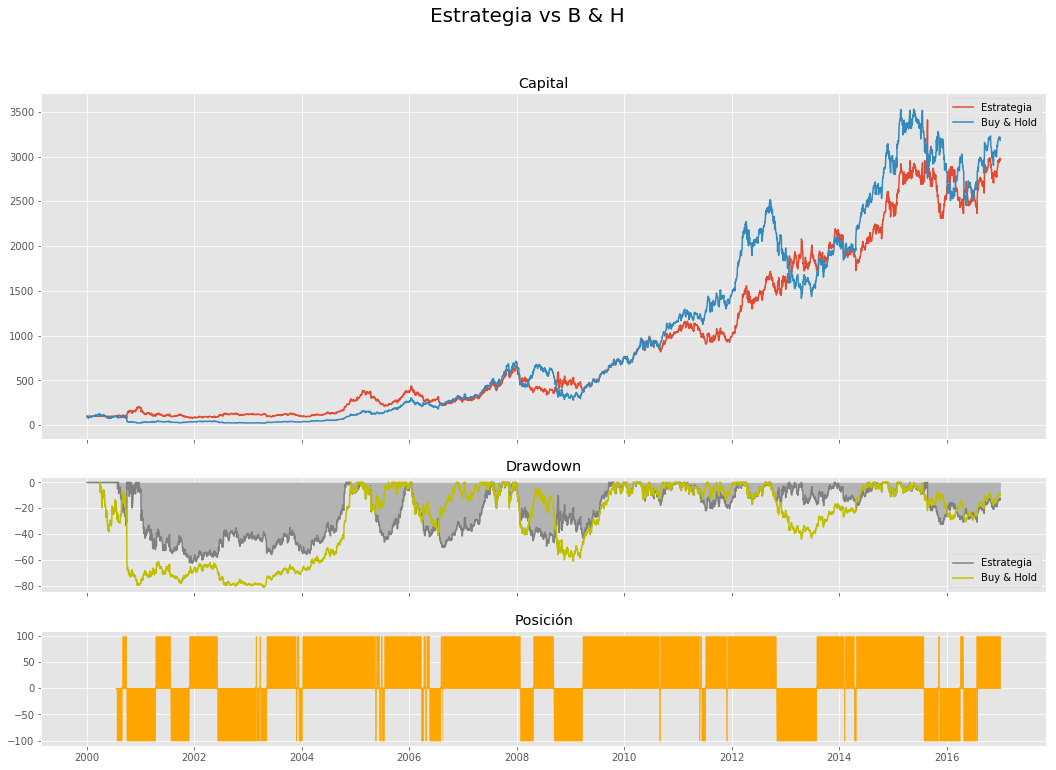

In [49]:
grafico(coleccion['estrategia_5_140'])


---


# PRUEBA FUERA DE LA MUESTRA

In [50]:
periodo_rapido = 5

periodo_lento = 140

out_sample= qd_data[data.shape[0]:].copy()

out_sample['Dif_Close'] = out_sample.Close.pct_change()
out_sample['Dif_Open'] = out_sample.Open.pct_change()


out_estr, out_resultado = estrategia_medias (out_sample, periodo_rapido, periodo_lento)


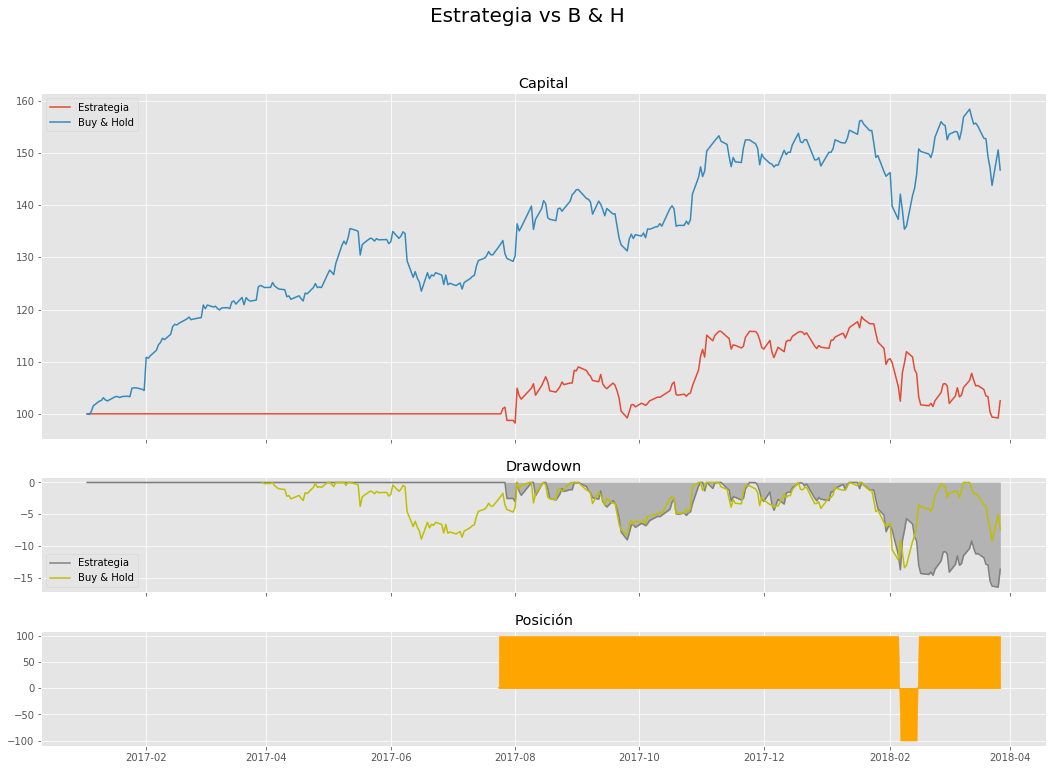

In [51]:
grafico(out_estr)

---